In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import random as random
import shutil

colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(list(mcolors.TABLEAU_COLORS)[:120])
markers_ls = ['o','s','v', '+', 'o', '*']
markers = itertools.cycle(markers_ls)

from scipy.special import psi
from scipy.special import polygamma
from scipy.special import erf, erfinv
from scipy.optimize import curve_fit

%matplotlib inline
mpl.style.use('classic')
mpl.style.use(['seaborn-whitegrid'])
from matplotlib.ticker import ScalarFormatter, NullFormatter
mpl.rcParams['figure.dpi'] = 400
mpl.rcParams.update({'font.size': 16})

current_dir = os.getcwd() 
kPSep = os.sep

import struct
FLOAT_SIZE = 8

directory = f'resultsClassical{kPSep}'

In [126]:
Lx = 6
Ly = 5
Ns = Lx * Ly
d = 2
bc = 1

Jdd = -1.0
cos_theta_af = None
cos_theta_f = None

if d == 1:
    cos_theta_af = np.array([1 if i % 2 == 0 else -1 for i in range(Lx)])
    cos_theta_f = np.ones(Lx)
else:
    cos_theta_af = []
    if Lx % 2 == 0:
        for j in range(Ly):
            for i in range(Lx):
                n = j * Lx + i
                cos_theta_af.append((1 if i % 2 == 0 else -1) if j % 2 == 0 else (-1 if i % 2 == 0 else 1))
        cos_theta_af = np.array(cos_theta_af)
    else:            
        cos_theta_af = np.array([1 if i%2==0 else -1 for i in range(Ns)])
    cos_theta_f = np.ones(Ns)

print(cos_theta_af)

values_f = 0
values_af = 0
for i in range(Ns):
    # nn right
    if bc == 0:
        values_f += cos_theta_f[i] * cos_theta_f[(i+1)%Ns] 
        values_f += cos_theta_f[i] * cos_theta_f[(i+Lx)%Ns]
        values_af += cos_theta_af[i] * cos_theta_af[(i+1)%Ns] 
        values_af += cos_theta_af[i] * cos_theta_af[(i+Lx)%Ns]
    else:
        if i != Ns-1:
            values_f += cos_theta_f[i] * cos_theta_f[i+1]
            values_af += cos_theta_af[i] * cos_theta_af[i+1]
        if i < Ns - Lx:
            values_f += cos_theta_f[i] * cos_theta_f[i+Lx]
            values_af += cos_theta_af[i] * cos_theta_af[i+Lx]

print(values_f, values_af)
            
    

en_ferro = Jdd * (np.sum(cos_theta_f[0:-1] * cos_theta_f[1:]) + np.sum(cos_theta_f[0:-Lx]*cos_theta_f[Lx:]))
en_aferro = Jdd * (np.sum(cos_theta_af[0:-1] * cos_theta_af[1:]) + np.sum(cos_theta_af[0:-Lx]*cos_theta_af[Lx:]))

en_ferro, en_aferro

[ 1 -1  1 -1  1 -1 -1  1 -1  1 -1  1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1 -1  1 -1]
53.0 -45


(-53.0, 45.0)

In [127]:
step = 0.1
step2 = 0.1
J_max = 2.0
J_min = -2.0



J_s = np.arange(J_min, J_max+step, step).astype(np.float16)
J_d = np.arange(J_min, J_max+step2, step).astype(np.float16)
J_s, len(J_s)

(array([-2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ,
        -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,
         0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,
         1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ], dtype=float16),
 41)

In [128]:
df = pd.read_csv(f"{directory}/type=square,_BC={bc},dim={d},Ns={Lx*Ly},Lx={Lx},Ly={Ly},Lz=1.dat", sep = '\t', names = ['J1','J2','E_ferro', 'E_aferro','E_ed','E_aed', 'idx']).dropna(axis = 1)
df['E_aferro'] -= en_aferro
df['E_ferro'] -= en_ferro
df['difference'] = df['E_aferro'] - df['E_ferro']
df[['E_ferro','E_aferro','E_ed','E_aed','difference']] /= Ns
print(df.dtypes)
df

J1            float64
J2            float64
E_ferro       float64
E_aferro      float64
E_ed          float64
E_aed         float64
difference    float64
dtype: object


,J1,J2,E_ferro,E_aferro,E_ed,E_aed,difference
0,-2.0,-2.0,-4.328826,-2.998183,0.0,0.0,1.330643
1,-2.0,-1.9,-4.901569,-2.192059,0.0,0.0,2.709510
2,-2.0,-1.8,-4.806434,-1.913428,0.0,0.0,2.893006
3,-2.0,-1.7,-2.197259,-2.988620,0.0,0.0,-0.791362
4,-2.0,-1.6,-3.731347,-3.249608,0.0,0.0,0.481738
...,...,...,...,...,...,...,...
856,-0.4,1.6,-1.807841,-0.828595,0.0,0.0,0.979246
857,-0.4,1.7,-1.654849,-0.919327,0.0,0.0,0.735522
858,-0.4,1.8,-1.912951,-0.960492,0.0,0.0,0.952459
859,-0.4,1.9,-1.871354,-1.123117,0.0,0.0,0.748237


In [130]:
#fig = plt.figure()
#ax = plt.axes(projection='3d')
x = np.array(df['J1']).flatten()
y = np.array(df['J2']).flatten()
z = np.array(df['difference']).flatten()
#ax.scatter3D(x,y,z)
x, y, z

(array([-2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. ,
        -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. ,
        -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. ,
        -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -1. , -1. , -1. ,
        -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
        -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
        -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
        -1. , -1. , -1. , -1. , -1. , -1.4, -1.4, -1.4, -1.4, -1.4, -1.4,
        -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4,
        -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4,
        -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4,
        -1.4, -1.4, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8,
        -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8,
        -0.8, -0.8, -0.8, -0.8, -0.8, 

In [131]:
tmp = df[['J1','J2','difference']].sort_values(['J1','J2']).astype(np.float32).drop_duplicates().reset_index().drop(columns=['index'])
print(tmp.dtypes)
tmp

J1            float32
J2            float32
difference    float32
dtype: object


,J1,J2,difference
0,-2.0,-2.0,1.330643
1,-2.0,-1.9,2.709510
2,-2.0,-1.8,2.893006
3,-2.0,-1.7,-0.791362
4,-2.0,-1.6,0.481738
...,...,...,...
856,2.0,1.6,-2.348966
857,2.0,1.7,-1.779467
858,2.0,1.8,-1.984077
859,2.0,1.9,-1.805590


In [132]:
import seaborn as sns
#fig, ax = plt.subplots(figsize = (10,10))
df_pivoted = tmp.pivot(columns='J1', index='J2', values='difference')
#c = ax.imshow(df_pivoted, cmap='RdYlGn')

#ax.set_yticks(np.arange(0, len(df_pivoted.columns)))
#ax.set_xticks(np.arange(-2.0, 2.0, 0.2), [str(i) for i in np.arange(-2.0, 2.0, 0.2)])
#ax.tick_params(labelrotation=0)
#fig.colorbar(c, ax=ax)
#plt.show()

df_pivoted

J1,-2.0,-1.8,-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,...,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0
J2,,,,,,,,,,,,,,,,,,,,,
-2.0,1.330643,2.094426,2.245883,2.546396,2.082184,1.733801,2.029585,1.345426,1.208086,0.495733,...,-0.766535,-1.479898,-1.487023,-1.783823,-1.133928,-1.485501,-2.239081,-2.374897,-2.318179,-1.944206
-1.9,2.709510,0.896204,1.562061,2.318344,1.791420,2.022432,1.980004,1.603373,0.956998,0.466692,...,-0.937034,-1.615988,-1.697386,-1.858642,-2.318919,-2.604772,-2.090608,-1.626206,-2.140184,-2.200847
-1.8,2.893006,2.843627,1.945386,2.350724,1.812607,1.969639,1.430872,1.311342,1.180971,0.160962,...,-0.602477,-1.059816,-1.861028,-1.067229,-1.946509,-1.444784,-2.167870,-2.117625,-0.490917,-2.241293
-1.7,-0.791362,1.579293,2.293029,1.839637,1.730976,1.552057,1.709096,1.479552,0.725581,0.387907,...,-0.773441,-1.209924,-1.812171,-1.716104,-1.745340,-1.726841,-2.242938,-2.436859,-1.267519,-0.041546
-1.6,0.481738,1.608606,1.245960,1.734884,1.443149,1.349478,1.412869,0.979041,1.216738,0.364367,...,-0.506023,-1.159841,-1.590858,-1.620286,-2.338924,-1.599053,-2.160588,-2.159450,-0.657537,-2.010411
-1.5,1.368827,2.860675,1.385258,1.369071,1.528805,1.354321,1.727677,1.423848,1.158995,0.499766,...,-0.925962,-1.404962,-1.479316,-1.211243,-1.780934,-0.937795,-0.857204,-2.085785,-2.058825,-2.877853
-1.4,1.977856,-0.619873,1.545265,-0.010830,0.913197,1.859493,1.418837,1.259352,1.118715,0.536613,...,-0.666240,-1.346947,-1.685349,-1.683841,-1.781073,-2.006075,-2.034859,-1.404791,-1.180003,-0.111619
-1.3,0.642752,1.952956,1.388276,1.559009,1.231390,1.553819,1.425984,1.124303,1.088946,0.402955,...,-0.686841,-1.358938,-1.731226,-1.416235,-3.231214,-0.572327,-1.177455,-1.492474,-2.064443,0.250182
-1.2,1.000540,1.067675,0.837621,1.167703,1.226419,1.292164,1.067270,0.944676,0.990602,0.532468,...,-0.798228,-1.046747,-1.346798,-1.607318,-1.415778,-0.851921,-2.211742,-0.496668,-1.694019,1.397861


41 21 41
(41, 21)
2.8930056 -3.435176


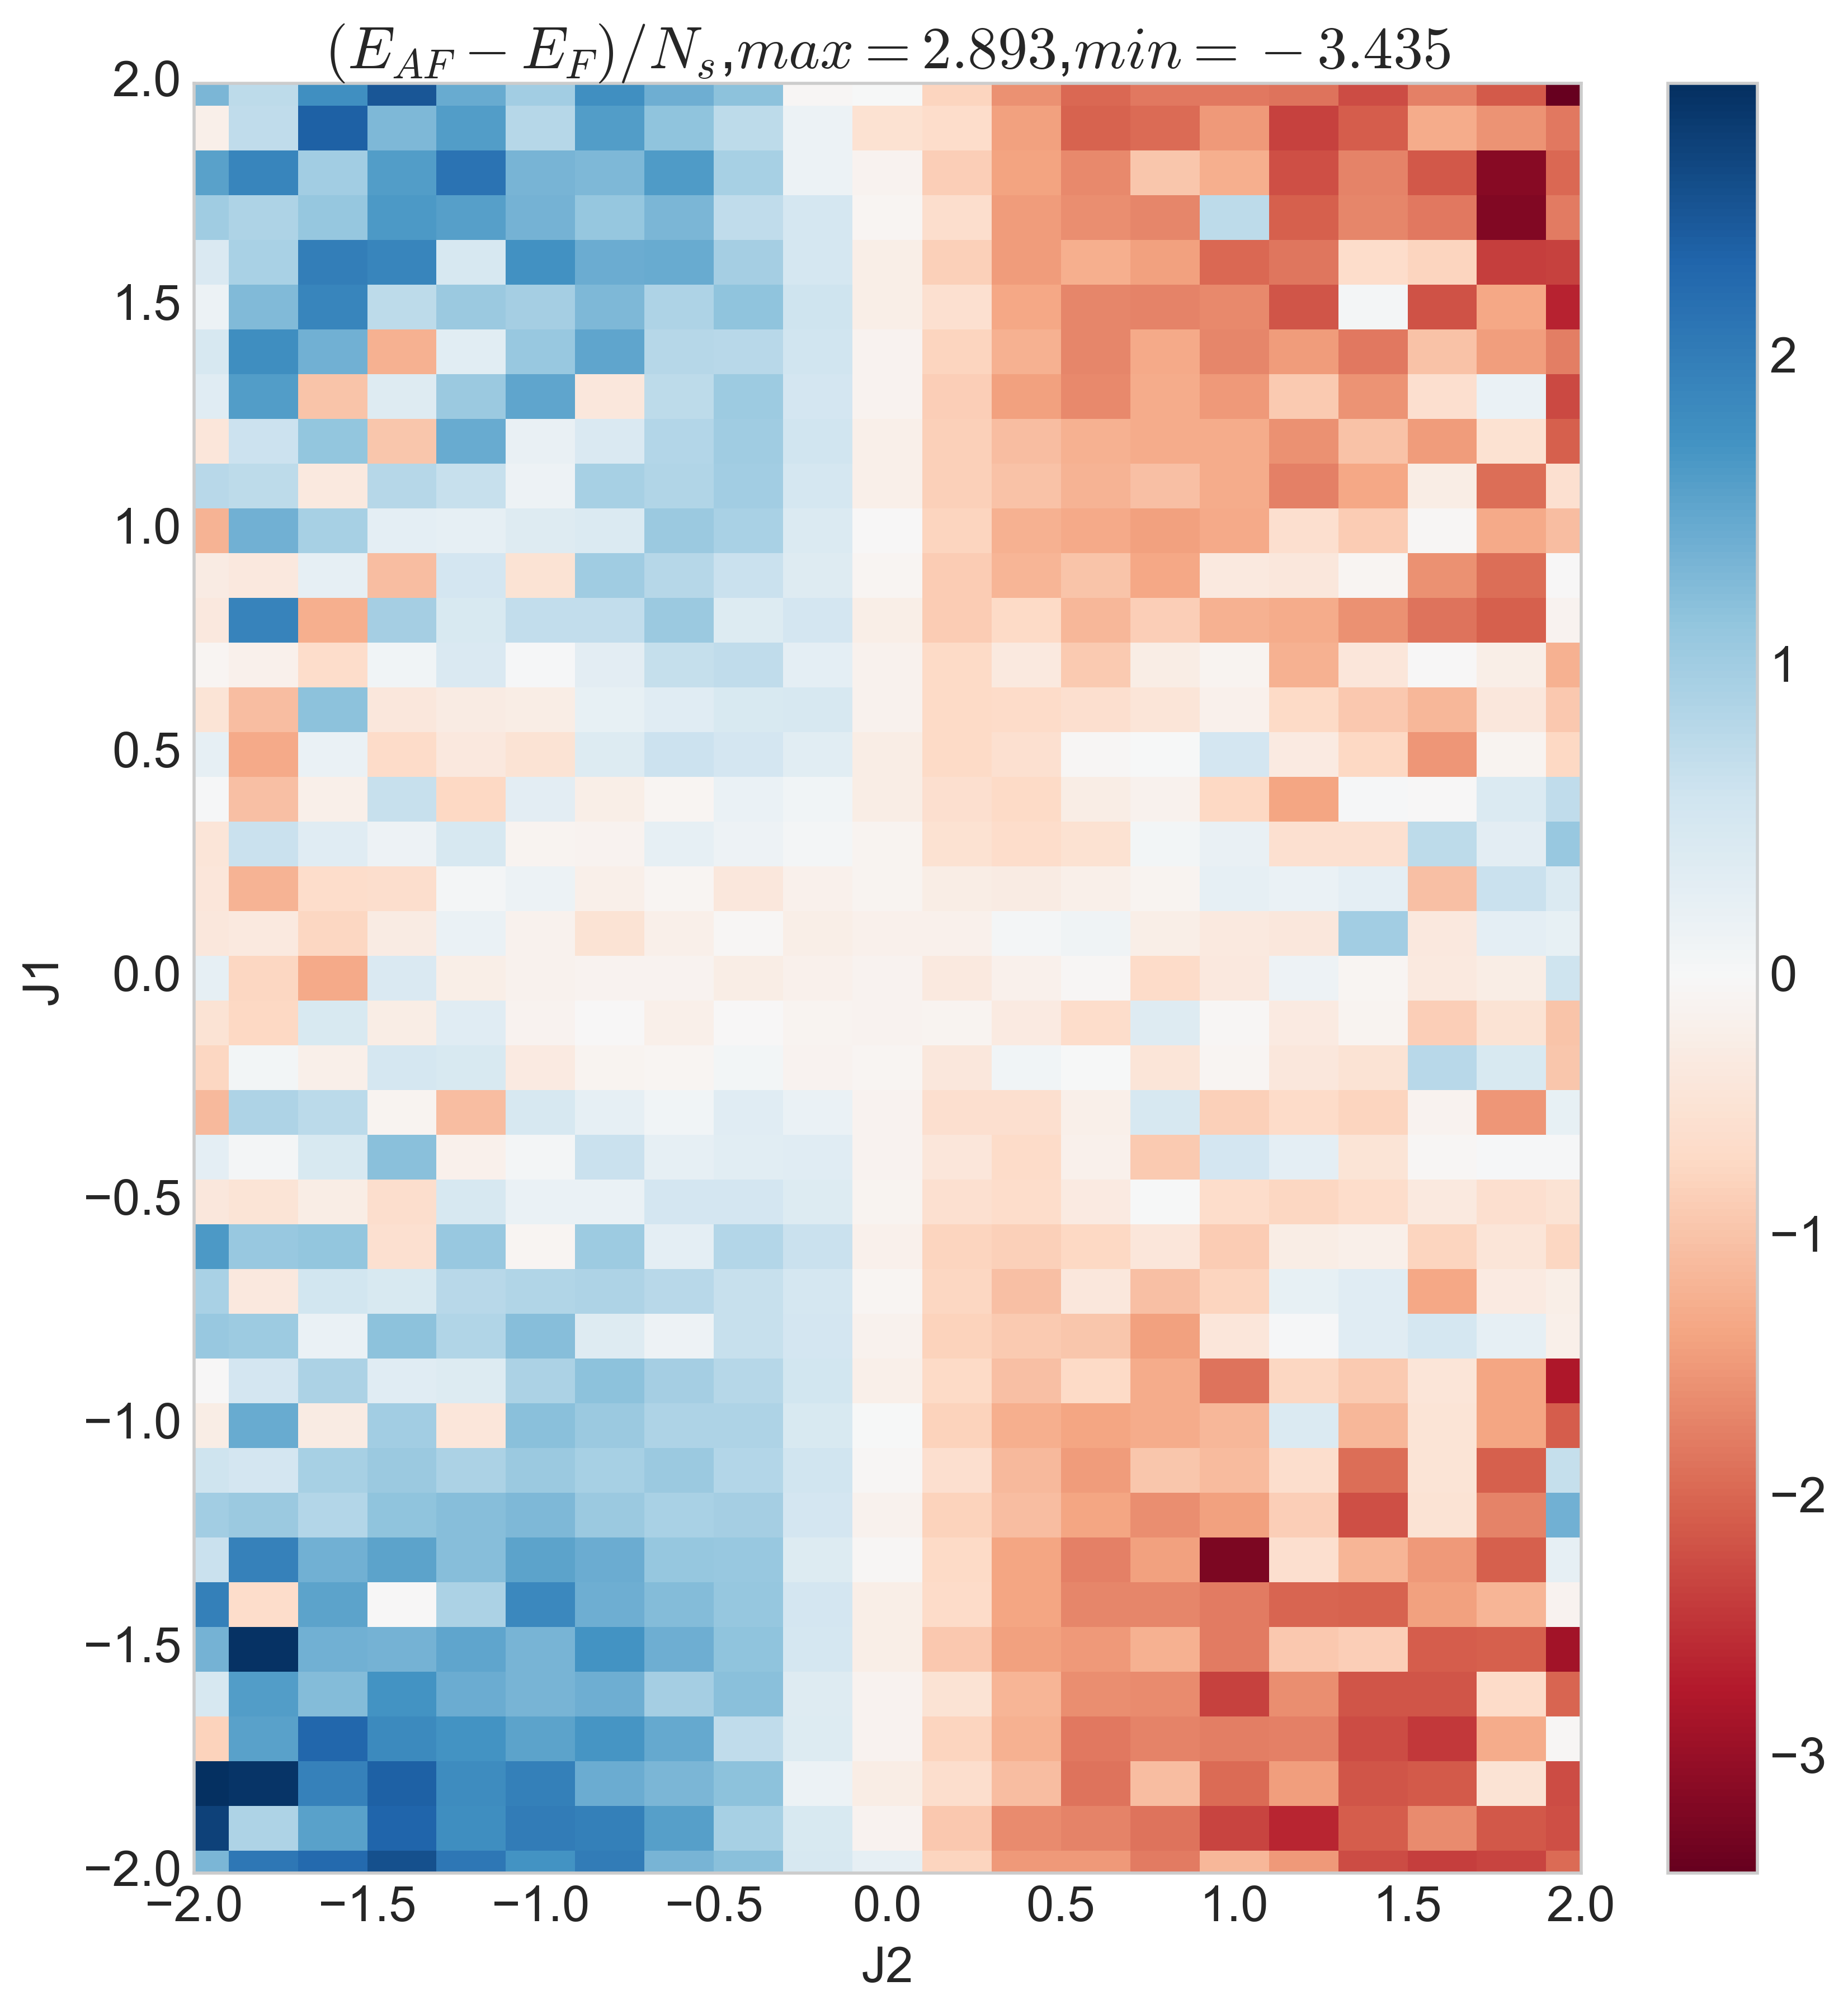

In [133]:
x, y = np.array(df_pivoted.index), np.array(df_pivoted.columns)
z = np.array(df_pivoted)
print(len(x), len(y),len(z))
print(z.shape)

iterator = 0

#z=z.reshape(len(x), len(y))
z_min, z_max = np.min(z), np.max(z)
print(z_max, z_min)
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlim(np.min(y), np.max(y))
ax.set_ylim(np.min(x), np.max(x))
ax.set_xlabel('J2')
ax.set_ylabel('J1')
ax.set_title('$(E_{AF} - E_{F})/N_s$,'+f'$max={z_max:.3f}$,$min={z_min:.3f}$')
ax.tick_params(labelrotation=0)
divnorm=mcolors.TwoSlopeNorm(vmin=z_min, vcenter=0., vmax=z_max)

c = ax.pcolormesh(y, x, z, cmap='RdBu', norm=divnorm)#, vmin=z_min, vmax=abs(z_min))
#c = ax.imshow(z)
#ax.set_xlim([np.min(x),np.max(x)])
#ax.set_ylim([np.min(y),np.max(y)])
fig.colorbar(c, ax=ax)
plt.show()

# EXTRACT

In [146]:
Lx = 5
Ly = 5
Ns = Lx * Ly
d = 2
bc = 1

Jdd = -1.0
cos_theta_af = None
cos_theta_f = None

if d == 1:
    cos_theta_af = np.array([1 if i % 2 == 0 else -1 for i in range(Lx)])
    cos_theta_f = np.ones(Lx)
else:
    cos_theta_af = []
    if Lx % 2 == 0:
        for j in range(Ly):
            for i in range(Lx):
                n = j * Lx + i
                cos_theta_af.append((1 if i % 2 == 0 else -1) if j % 2 == 0 else (-1 if i % 2 == 0 else 1))
        cos_theta_af = np.array(cos_theta_af)
    else:            
        cos_theta_af = np.array([1 if i%2==0 else -1 for i in range(Ns)])
    cos_theta_f = np.ones(Ns)

print(cos_theta_af)

en_ferro = Jdd * np.sum(cos_theta_f[0:-1] * cos_theta_f[1:])
en_aferro = Jdd * np.sum(cos_theta_af[0:-1] * cos_theta_af[1:])

en_ferro, en_aferro

[ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
  1]


(-24.0, 24.0)

In [147]:
dir = lambda lx, ly, bc, d, typ : f"./{directory}/{typ},Lx={lx},Ly={ly},bc={bc},d={d}/"
d = dir(Lx, Ly, bc, d, 'ferro')
d

'./resultsClassical\\/ferro,Lx=5,Ly=5,bc=1,d=2/'

In [160]:
dir_inner = lambda dir, n_vis, lr, J, Jz, Jdd :f"{dir}n_visible={n_vis},n_hidden={(2*n_vis)},batch=1024,lr={lr:.2f}/__hei_dots,dN={n_vis},Ns={n_vis},J={J:.2f},Jx=0.00,Jy=0.00,Jz={Jz:.2f},d=1.00,J0=0.00,Jdd={Jdd:.2f}/"

dd =dir_inner(d, Ns, 0.00, J=0.60, Jz=-1.30, Jdd=-1.0)
dd

'./resultsClassical\\/ferro,Lx=5,Ly=5,bc=1,d=2/n_visible=25,n_hidden=50,batch=1024,lr=0.00/__hei_dots,dN=25,Ns=25,J=0.60,Jx=0.00,Jy=0.00,Jz=-1.30,d=1.00,J0=0.00,Jdd=-1.00/'

(<AxesSubplot:>,
 energy   -58.164219
 dtype: float64)

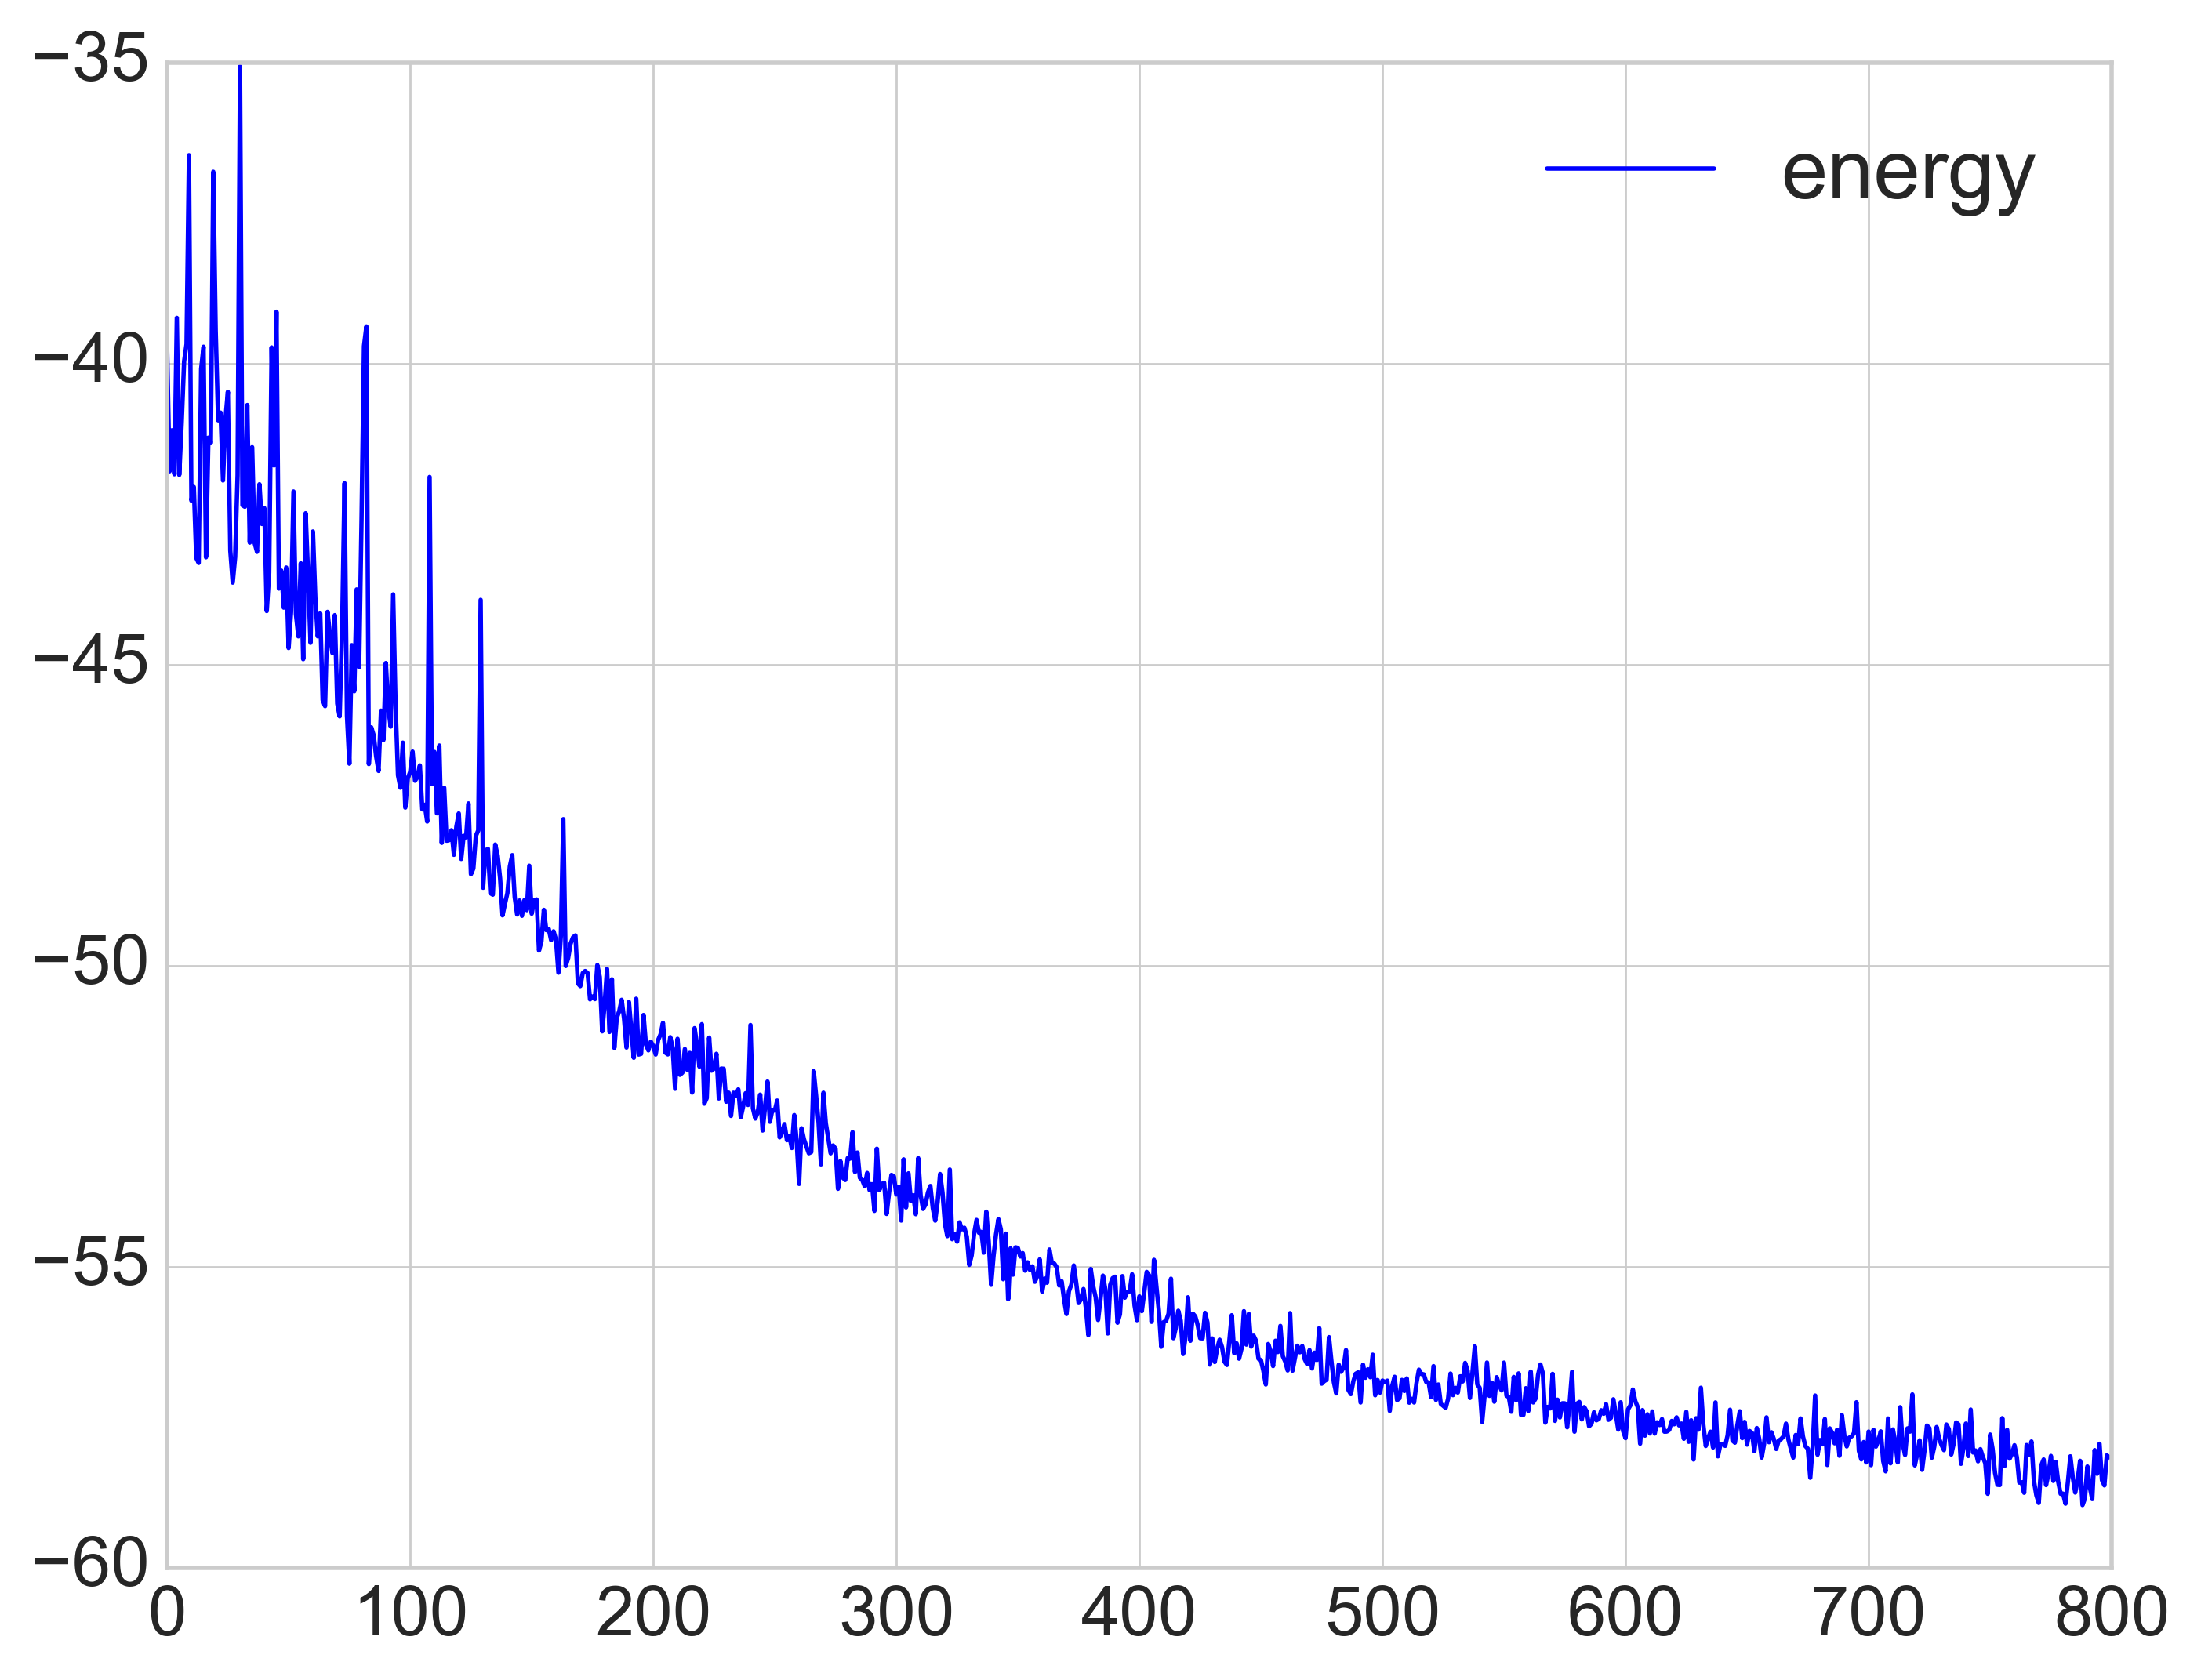

In [161]:
os.listdir(dd)
df = pd.read_csv(dd+'energies.dat', sep = '\t', index_col=0, names=['energy','s']).drop(columns=['s'])

df.plot(), df.tail(100).mean()

# OTHERS

In [5]:
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_x = np.array([[0,1],[1,0]])
sigma_z = np.array([[1, 0],[0, -1]])
ones = np.eye(2)
sigma_y, sigma_x, sigma_z, ones

(array([[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]]),
 array([[0, 1],
        [1, 0]]),
 array([[ 1,  0],
        [ 0, -1]]),
 array([[1., 0.],
        [0., 1.]]))

In [6]:
sigma_y_1 = np.kron(sigma_y, ones)
sigma_x_1 = np.kron(sigma_x, ones)
sigma_z_1 = np.kron(sigma_z, ones)
sigma_y_1, sigma_x_1

(array([[0.+0.j, 0.+0.j, 0.-1.j, 0.-0.j],
        [0.+0.j, 0.+0.j, 0.-0.j, 0.-1.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]]),
 array([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]]))

In [7]:
sigma_y_0 = np.kron(ones, sigma_y)
sigma_x_0 = np.kron(ones, sigma_x)
sigma_z_0 = np.kron(ones, sigma_z)
sigma_y_0, sigma_x_0, sigma_z_0

(array([[0.+0.j, 0.-1.j, 0.+0.j, 0.-0.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.-0.j, 0.+0.j, 0.-1.j],
        [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j]]),
 array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]]),
 array([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0., -0.],
        [ 0.,  0.,  1.,  0.],
        [ 0., -0.,  0., -1.]]))

In [8]:
#|00>=|1000>
# flips
state = np.array([1,0,0,0])
flip0 = sigma_x_0.dot(state)
spin0 = sigma_z_0.dot(state)
print(flip0, spin0)
flip1 = sigma_x_1.dot(state)
spin1 = sigma_z_1.dot(state)
print(flip1, spin1)


s0 = -1
s1 = -1
state_changed = sigma_y_1.dot(state)
sigma_y_0.dot(state_changed)

[0. 1. 0. 0.] [1. 0. 0. 0.]
[0. 0. 1. 0.] [1. 0. 0. 0.]


array([ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j])

In [9]:
#|00>=|0100>
# flips
state = np.array([0,1,0,0])
flip0 = sigma_x_0.dot(state)
spin0 = sigma_z_0.dot(state)
print(flip0, spin0)
flip1 = sigma_x_1.dot(state)
spin1 = sigma_z_1.dot(state)
print(flip1, spin1)


s0 = -1
s1 = -1
state_changed = sigma_y_1.dot(state)
sigma_y_0.dot(state_changed)

[1. 0. 0. 0.] [ 0. -1.  0.  0.]
[0. 0. 0. 1.] [0. 1. 0. 0.]


array([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

In [10]:
#|01>=|0010>
# flips
state = np.array([0,0,1,0])
flip0 = sigma_x_0.dot(state)
spin0 = sigma_z_0.dot(state)
print(flip0, spin0)
flip1 = sigma_x_1.dot(state)
spin1 = sigma_z_1.dot(state)
print(flip1, spin1)


s0 = -1
s1 = -1
state_changed = sigma_y_1.dot(state)
sigma_y_0.dot(state_changed)

[0. 0. 0. 1.] [0. 0. 1. 0.]
[1. 0. 0. 0.] [ 0.  0. -1.  0.]


array([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])

In [11]:
#|11>=|0001>
# flips
state = np.array([0,0,0,1])
flip0 = sigma_x_0.dot(state)
spin0 = sigma_z_0.dot(state)
print(flip0, spin0)
flip1 = sigma_x_1.dot(state)
spin1 = sigma_z_1.dot(state)
print(flip1, spin1)


s0 = -1
s1 = -1
state_changed = sigma_y_1.dot(state)
sigma_y_0.dot(state_changed)

[0. 0. 1. 0.] [ 0.  0.  0. -1.]
[0. 1. 0. 0.] [ 0.  0.  0. -1.]


array([-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j])

In [12]:
sigma_x_1*sigma_x_0 - sigma_x_0*sigma_x_1

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [13]:
sigma_y_1*sigma_y_0 - sigma_y_0*sigma_y_1

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [14]:
sigma_z_1*sigma_z_0 - sigma_z_0*sigma_z_1

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])